In [1]:

import os, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer

# Files
FEATURES_CSV = "features.csv"
EMB_NPY = "embeddings.npy"
EMB_META = "embedding_meta.csv"
MODEL_PKL = "emotion_logreg.pkl"
TALK_FEATS_CSV = "talk_features.csv"  # optional (from Notebook 04)

PRED_CHUNKS_CSV = "predictions_per_chunk.csv"
TALK_SUMMARY_CSV = "talk_summary.csv"

# Make figure dir
Path("figures").mkdir(exist_ok=True)


In [2]:

feats = pd.read_csv(FEATURES_CSV)
print("features.csv rows:", len(feats))
keep = ["talk_id","chunk_id","title","speaker","primary_emotion","frames","techniques"]
if "chunk_text" in feats.columns: keep.append("chunk_text")
feats = feats[ [c for c in keep if c in feats.columns] ].copy()
feats.head(3)


features.csv rows: 16128


,talk_id,chunk_id,title,speaker,primary_emotion,frames,techniques
0,0,0,Averting the climate crisis,Al Gore,neutral,none,"storytelling, rhetorical_question"
1,0,1,Averting the climate crisis,Al Gore,neutral,environmental,"storytelling, rhetorical_question"
2,0,2,Averting the climate crisis,Al Gore,neutral,environmental,rhetorical_question


In [4]:

# Prefer precomputed embeddings; fallback to TF-IDF on chunk_text
X, X_source = None, ""
if Path(EMB_NPY).exists() and Path(EMB_META).exists():
    emb = np.load(EMB_NPY)
    meta = pd.read_csv(EMB_META)
    kf = feats.set_index(["talk_id","chunk_id"]).sort_index()
    km = meta.set_index(["talk_id","chunk_id"]).sort_index()
    common = kf.index.intersection(km.index)
    if len(common) == 0:
        raise ValueError("No overlap between features.csv and embedding_meta.csv on (talk_id, chunk_id).")
    kf = kf.loc[common]
    km = km.loc[common]
    order = km.reset_index().index.values
    X = emb[order]
    feats = kf.reset_index()
    X_source = "embeddings"
    print("Using embeddings:", X.shape)
else:
    assert "chunk_text" in feats.columns, "No embeddings found and no chunk_text for TF‑IDF fallback."
    tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=2)
    X = tfidf.fit_transform(feats["chunk_text"].fillna(" ")).astype("float32")
    X_source = "tfidf"
    print("Using TF‑IDF:", X.shape)


Using embeddings: (1500, 1536)


In [5]:

with open(MODEL_PKL, "rb") as f:
    pack = pickle.load(f)
clf = pack["model"]
scaler = pack.get("scaler", None)
labels = pack.get("labels", None)
print("Model loaded. Trained on:", pack.get("feature_source","unknown"))

# Apply scaler if needed
if scaler is not None and not hasattr(X, "toarray"):
    X_inf = scaler.transform(X)
else:
    X_inf = X


Model loaded. Trained on: embeddings


In [6]:

pred = clf.predict(X_inf)
feats_pred = feats.copy()
feats_pred["pred_emotion"] = pred

# Save per-chunk predictions
feats_pred.to_csv(PRED_CHUNKS_CSV, index=False)
print("Wrote:", PRED_CHUNKS_CSV)
feats_pred.head(3)


Wrote: predictions_per_chunk.csv


,talk_id,chunk_id,title,speaker,primary_emotion,frames,techniques,pred_emotion
0,0,3,Averting the climate crisis,Al Gore,hope,environmental,rhetorical_question,hope
1,3,0,Greening the ghetto,Majora Carter,joy,environmental,"storytelling, statistic, contrast",joy
2,4,1,Do schools kill creativity?,Sir Ken Robinson,neutral,none,"storytelling, rhetorical_question",neutral


In [7]:

from collections import Counter

agg = []
for talk_id, g in feats_pred.groupby("talk_id"):
    title = g["title"].iloc[0] if "title" in g.columns else ""
    speaker = g["speaker"].iloc[0] if "speaker" in g.columns else ""

    # Predicted emotion trajectory
    g2 = g.sort_values("chunk_id")
    traj = g2["pred_emotion"].tolist()
    final_pred = traj[-1] if len(traj) else "neutral"
    dominant_pred = Counter(traj).most_common(1)[0][0] if traj else "neutral"

    # Optional counts from labels
    def _split_col(series):
        vals = []
        for v in series.fillna(""):
            vals.extend([p.strip() for p in str(v).split(",") if p.strip()])
        return vals
    frames_count = len(_split_col(g["frames"])) if "frames" in g.columns else 0
    techniques_count = len(_split_col(g["techniques"])) if "techniques" in g.columns else 0

    agg.append({
        "talk_id": talk_id,
        "title": title,
        "speaker": speaker,
        "n_chunks": len(g),
        "final_pred_emotion": final_pred,
        "dominant_pred_emotion": dominant_pred,
        "frames_count": frames_count,
        "techniques_count": techniques_count
    })

talk_summary = pd.DataFrame(agg).sort_values("talk_id")
talk_summary.to_csv(TALK_SUMMARY_CSV, index=False)
print("Wrote:", TALK_SUMMARY_CSV)
talk_summary.head(3)


Wrote: talk_summary.csv


,talk_id,title,speaker,n_chunks,final_pred_emotion,dominant_pred_emotion,frames_count,techniques_count
0,0,Averting the climate crisis,Al Gore,1,hope,hope,1,1
1,3,Greening the ghetto,Majora Carter,1,joy,joy,1,3
2,4,Do schools kill creativity?,Sir Ken Robinson,1,neutral,neutral,1,2


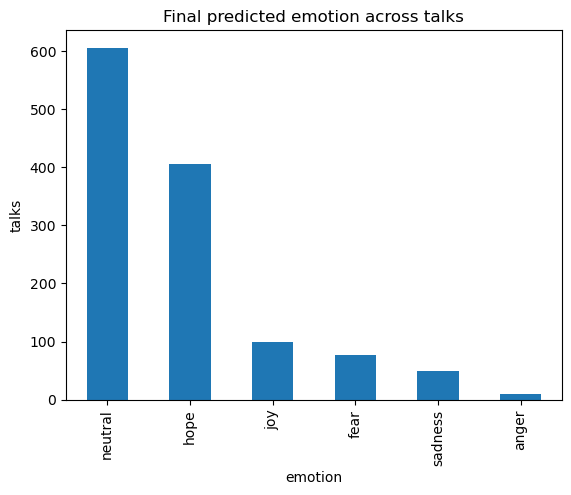

In [8]:

plt.figure()
talk_summary["final_pred_emotion"].value_counts().plot(kind="bar")
plt.title("Final predicted emotion across talks")
plt.xlabel("emotion"); plt.ylabel("talks")
plt.savefig("figures/final_pred_emotion_distribution.png", dpi=200, bbox_inches="tight")
plt.show()


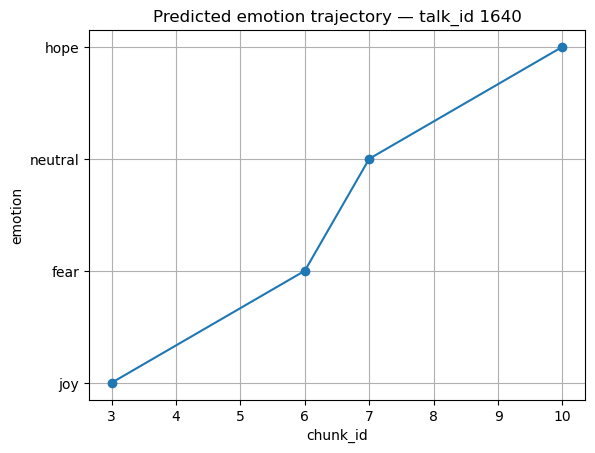

In [9]:

counts = feats_pred.groupby("talk_id")["chunk_id"].count().sort_values(ascending=False)
example_id = counts.index[0]
one = feats_pred[feats_pred["talk_id"]==example_id].sort_values("chunk_id")
emos = one["pred_emotion"].tolist()
uniq = list(dict.fromkeys(emos))
emap = {e:i for i,e in enumerate(uniq)}
y = [emap[e] for e in emos]

plt.figure()
plt.plot(one["chunk_id"], y, marker="o")
plt.yticks(list(emap.values()), list(emap.keys()))
plt.title(f"Predicted emotion trajectory — talk_id {int(example_id)}")
plt.xlabel("chunk_id"); plt.ylabel("emotion")
plt.grid(True)
plt.savefig("figures/example_emotion_trajectory.png", dpi=200, bbox_inches="tight")
plt.show()
